In [ ]:
import numpy as np
import pandas as pd
import time
from collections import defaultdict as dd

import matplotlib.pyplot as plt

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# file_name = 'word_stream.txt'
# file_id = ''
# downloaded = drive.CreateFile({'id': file_id})
# downloaded.GetContentFile(file_name)

counts_file = 'counts.txt'
file_id = '1EI3WoW26HUqGA-Q3jR_TFbjjh1MUnFmj'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(counts_file)

sm_counts_file = 'counts_tiny.txt'
file_id = '1-5EcUFw5-GN1xN3nutNw2ay4ibwbXgXW'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(sm_counts_file)

word_stream_file = 'word_stream.txt' 
file_id = '1XQfDi8SPywzdBzr9s5iEWvaiEWYBmkql'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(word_stream_file)

sm_word_stream_file = 'word_stream_tiny.txt'
file_id = '1QVqUwM-cRDg2iDGCJilC3See3qQ2k3Lq'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(sm_word_stream_file)

hash_params_file = 'hash_params.txt'
file_id = '16SL09H7qYLwgN-mQ1EqyABfQl5FRsMX-'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(hash_params_file)

In [ ]:
def hash_fun(a, b, p, n_buckets, x):
    y = x % p
    hash_val = (a*y + b) % p
    return hash_val % n_buckets

In [ ]:
def get_hash_params(file_path, p, num_buckets):
    hash_params_list = []
    with open(file_path, "r") as f:
        hash_params_list = f.readlines()

    hash_params_list = list(map(str.strip, hash_params_list))
    hash_params_list = list(map(str.split, hash_params_list))
    hash_params_dict = {j : 
                            {
                                'a':int(a),
                                'b':int(b), 
                                'hash': hash_fun, 
                                'counts': dd(int)
                            } for j, (a, b) in enumerate(hash_params_list)
                        }

    return hash_params_dict

In [ ]:
def process_word_stream(file_path, hash_params, p, num_buckets):
    with open(file_path) as fp:
        line = fp.readline()
        cnt = 1
        while line:
            x = int(line.strip())
            for j, hash_info in hash_params.items():
                a = hash_info['a']
                b = hash_info['b']
                counts = hash_info['counts']

                hash_val = hash_info['hash'](a, b, p, num_buckets, x)
                counts[hash_val] += 1
            
            line = fp.readline()
            cnt += 1
    
    return

In [ ]:
def get_counts(file_path, hash_params, p, num_buckets):
    word_counts = dd(dict)

    with open(file_path) as fp:
        line = fp.readline()
        while line:
            x, freq  = list(map(int, line.strip().split('\t')))
            x_counts = []
            for j, hash_info in hash_params.items():
                a = hash_info['a']
                b = hash_info['b']
                counts = hash_info['counts']

                hash_val = hash_info['hash'](a, b, p, num_buckets, x)
                x_counts.append(counts[hash_val]) # index of list = j
            freq_estimate = min(count for count in x_counts if count > 0)
            
            word_counts[x]['actual'] = freq
            word_counts[x]['estimate'] = freq_estimate
            word_counts[x]['j'] = x_counts.index(freq_estimate)
            
            line = fp.readline()
        
    return word_counts

In [ ]:
def get_error_plot(word_counts):
    def compute_error(actual, estimated):
	    return float(estimated - actual) / actual
    
    error = []
    word_freq = []

    for word, info in word_counts.items():
        actual, estimated = info['actual'], info['estimate']
        
        error.append(compute_error(actual, estimated))
        word_freq.append(actual)
    
    plt.figure(figsize=(14, 10))
    plt.loglog(word_freq, error, "+")
    plt.title("Relative Error vs Word Frequency")
    plt.xlabel("Word Frequency (log)")
    plt.ylabel("Relative Error (log)")
    plt.grid()
    plt.show()

    plt.savefig("error_freq_graph.png")

In [ ]:
delta = np.e ** -5
epsilon = np.e * (10 ** -4)
p = 123457
num_buckets = int(np.ceil(np.e / epsilon))

In [ ]:
hash_params = get_hash_params(hash_params_file, p, num_buckets)
hash_params

{0: {'a': 3,
  'b': 1561,
  'counts': defaultdict(int, {}),
  'hash': <function __main__.hash_fun>},
 1: {'a': 17,
  'b': 277,
  'counts': defaultdict(int, {}),
  'hash': <function __main__.hash_fun>},
 2: {'a': 38,
  'b': 394,
  'counts': defaultdict(int, {}),
  'hash': <function __main__.hash_fun>},
 3: {'a': 61,
  'b': 13,
  'counts': defaultdict(int, {}),
  'hash': <function __main__.hash_fun>},
 4: {'a': 78,
  'b': 246,
  'counts': defaultdict(int, {}),
  'hash': <function __main__.hash_fun>}}

In [ ]:
start_time = time.time()

process_word_stream(word_stream_file, hash_params, p, num_buckets)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Time Taken: {elapsed_time} seconds')

Time Taken: 695.6675503253937 seconds


In [ ]:
word_counts = get_counts(counts_file, hash_params, p, num_buckets)

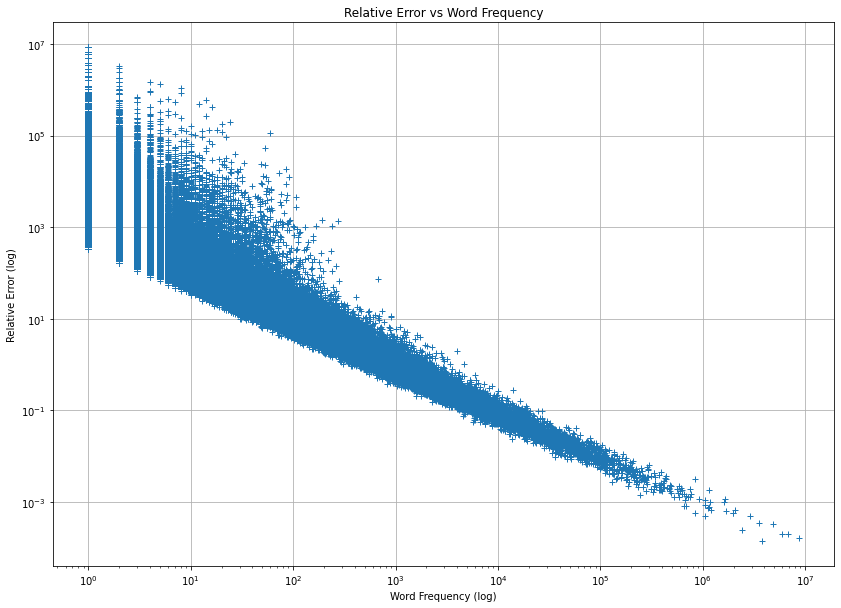

<Figure size 432x288 with 0 Axes>

In [ ]:
get_error_plot(word_counts)